In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the paths for dataset and processed dataset
train_dir = '/content/drive/MyDrive/Facial  Recognition /train/train'
test_dir = '/content/drive/MyDrive/Facial  Recognition /test/test'
processed_dataset_dir = '/content/drive/My Drive/processed_facial_expression_dataset'  # Update with your processed dataset path

# Define the classes for facial expressions
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Mapping from class names to numerical labels
class_to_label = {cls: label for label, cls in enumerate(classes)}

# Initialize empty lists to store images and labels
images = []
labels = []

image_width = 48
image_height = 48

# Function to process the dataset
def process_dataset(directory):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        for image_filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_AREA)
            images.append(image)
            labels.append(class_to_label[cls])

# Process both train and test datasets
process_dataset(train_dir)
process_dataset(test_dir)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize pixel values to range [0, 1]
images = images.astype('float32') / 255.0

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




Epoch 1/50
897/897 [==============================] - 34s 27ms/step - loss: 1.9628 - accuracy: 0.3009 - val_loss: 1.6342 - val_accuracy: 0.3547 - lr: 0.0010
Epoch 2/50
897/897 [==============================] - 24s 26ms/step - loss: 1.6055 - accuracy: 0.3821 - val_loss: 1.3904 - val_accuracy: 0.4703 - lr: 0.0010
Epoch 3/50
897/897 [==============================] - 23s 26ms/step - loss: 1.4665 - accuracy: 0.4362 - val_loss: 1.4002 - val_accuracy: 0.4657 - lr: 0.0010
Epoch 4/50
897/897 [==============================] - 21s 24ms/step - loss: 1.3914 - accuracy: 0.4651 - val_loss: 1.3598 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 5/50
897/897 [==============================] - 21s 24ms/step - loss: 1.3450 - accuracy: 0.4917 - val_loss: 1.3459 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 6/50
897/897 [==============================] - 22s 25ms/step - loss: 1.3157 - accuracy: 0.4985 - val_loss: 1.2480 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 7/50
897/897 [==============================] - 21s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


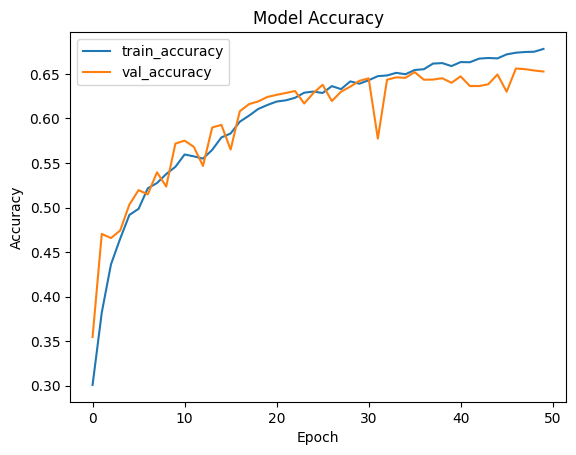

In [ ]:
# Learning rate scheduler
def lr_scheduler(epoch):
    lr = 0.001
    if epoch > 15:
        lr *= 0.5
    elif epoch > 30:
        lr *= 0.2
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(datagen.flow(x_train.reshape(-1, image_width, image_height, 1), y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=50,
                    validation_data=(x_test.reshape(-1, image_width, image_height, 1), y_test),
                    callbacks=[scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(x_test.reshape(-1, image_width, image_height, 1), y_test)
print(f"Test accuracy: {accuracy:.4f}")

# Save the model
model.save('/content/drive/My Drive/facial_expression_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()